台灣最常見的八哥有 (土) 八哥、白尾八哥及家八哥三種。我們來挑戰每種八哥只用三張照片, 看能不能打造一個神經網路學會辨識這三種八哥。

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

### 1. 讀入八哥資料圖檔

這裡把在 GitHub 上 `myna.zip` 的八哥照片集讀進來。

In [4]:
!wget --no-check-certificate \
    https://github.com/yenlung/Deep-Learning-Basics/raw/master/images/myna.zip \
    -O /content/myna.zip

--2023-04-22 19:18:04--  https://github.com/yenlung/Deep-Learning-Basics/raw/master/images/myna.zip
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/yenlung/Deep-Learning-Basics/master/images/myna.zip [following]
--2023-04-22 19:18:04--  https://raw.githubusercontent.com/yenlung/Deep-Learning-Basics/master/images/myna.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 964098 (942K) [application/zip]
Saving to: ‘/content/myna.zip’

/content/myna.zip   100%[===================>] 941.50K  --.-KB/s    in 0.02s   

2023-04-22 19:18:04 (50.2 MB/s) - ‘/content/myna.zip’ saved [964098/964098]



In [5]:
import os
import zipfile

local_zip = '/content/myna.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

大家在處理照片時，常會想，要怎麼標記呢? 其實可以像這樣子: 有三個類別, 就用三個資料夾存, 每個資料夾裡的照片讀出來, 就用 0, 1, 2 來標記!

### 2. 把八哥照片轉成訓練資料


In [6]:
base_dir = '/content/'

In [7]:
myna_folders = ['crested_myna', 'javan_myna', 'common_myna']

我們可以列出在某個資料夾的檔名! 比方說土八哥是這樣。

In [8]:
thedir = base_dir + myna_folders[0]
os.listdir(thedir)

['crested_myna03.jpg', 'crested_myna02.jpg', 'crested_myna01.jpg']

做成輸入 (data)、輸出 (target)。

In [9]:
data = []
target = []

for i in range(3):
    thedir = base_dir + myna_folders[i]
    myna_fnames = os.listdir(thedir)
    for myna in myna_fnames:
        img = load_img(thedir + '/' + myna, target_size = (256,256))
        x = img_to_array(img)
        data.append(x)
        target.append(i)


In [10]:
data = np.array(data)

我們選張八哥圖來看看。

In [11]:
len(data)

23

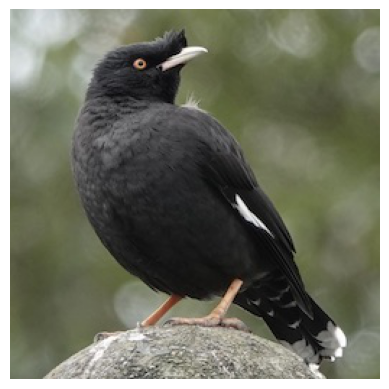

In [12]:
n=1
plt.axis('off')
plt.imshow(data[n]/255);

看來沒有什麼意外, 就是個鳥圖。我們用 ResNet 的預處理再看一次。

In [13]:
x_train = preprocess_input(data)

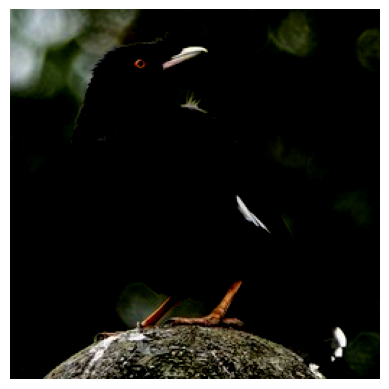

In [14]:
plt.axis('off')
plt.imshow(x_train[n]);

一個答案就是 0, 1, 2 其中一個數字。

In [15]:
target[n]

0

做 one-hot enconding。

In [16]:
y_train = to_categorical(target, 3)

In [17]:
y_train[n]

array([1., 0., 0.], dtype=float32)

### 3. 用 ResNet50 打造我們的神經網路

ResNet50 是 2015 ImageNet 的冠軍, 我們用第二版來試試。原本 ImageNet 是做了 1,000 個類別的圖形辨識。我們想直接用來辨識八哥, 就是把最後一層 (通常就 1,000 個輸出的 dense 層) 砍掉 (`include_top=False`), 然後換我們的就好。

再來我們可以把每個 filter 的結果做個大總合, 例如算每個 filter 計分板的總平均 (global avg pooling), 這本來該我們自己做, 但是 `tf.Keras` 是善良無比的幫我們做好。只要下個參數 `pooling="avg"`)。

In [18]:
resnet = ResNet50V2(include_top=False, pooling="avg")

94668760/94668760 [==============================] - 3s 0us/step


我們是遷移式學習, 原本 ResNet 的部份我們當然沒有重新訓練的意思。於是就設這邊不需要訓練。

In [19]:
resnet.trainable = False

再來就是正式打造我們遷移學習版的函數學習機! 可以發現我們只是加入了最後一層...

In [20]:
model = Sequential()

In [21]:
model.add(resnet)

In [22]:
model.add(Dense(3, activation='softmax'))

#### 組裝我們的函數學習機

這裡我們用分類時非常標準的 `categorical_crossentropy`, 順便試試有名的 `adam` 學習法。

In [23]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

#### 欣賞我們的神經網路

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 dense (Dense)               (None, 3)                 6147      
                                                                 
Total params: 23,570,947
Trainable params: 6,147
Non-trainable params: 23,564,800
_________________________________________________________________


我們可以發現原來有超過兩千萬個參數, 經我們偷來, 不是, 借來以後, 只有 6,147 個參數要調。

### 4. 訓練 fit

這裡我們全部的資料也只有 23 筆, 所以 `batch_size` 就選擇 23 了...

In [25]:
model.fit(x_train, y_train, batch_size=23, epochs=10)

Epoch 1/10
1/1 [==============================] - 12s 12s/step - loss: 0.9404 - accuracy: 0.6522
Epoch 2/10
1/1 [==============================] - 0s 82ms/step - loss: 0.8127 - accuracy: 0.6957
Epoch 3/10
1/1 [==============================] - 0s 82ms/step - loss: 0.7221 - accuracy: 0.7391
Epoch 4/10
1/1 [==============================] - 0s 81ms/step - loss: 0.6389 - accuracy: 0.7826
Epoch 5/10
1/1 [==============================] - 0s 93ms/step - loss: 0.5616 - accuracy: 0.7826
Epoch 6/10
1/1 [==============================] - 0s 83ms/step - loss: 0.4910 - accuracy: 0.8261
Epoch 7/10
1/1 [==============================] - 0s 84ms/step - loss: 0.4273 - accuracy: 0.9130
Epoch 8/10
1/1 [==============================] - 0s 83ms/step - loss: 0.3712 - accuracy: 0.9565
Epoch 9/10
1/1 [==============================] - 0s 80ms/step - loss: 0.3237 - accuracy: 1.0000
Epoch 10/10
1/1 [==============================] - 0s 80ms/step - loss: 0.2843 - accuracy: 1.0000


### 5. 預測

對了, 為何這次我們沒有切測試一一資料呢? 那是因為畢竟我們每張八哥沒多少照片...

In [26]:
y_predict = np.argmax(model.predict(x_train), -1)

1/1 [==============================] - 1s 1s/step


In [27]:
y_predict

array([0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2])

好奇的話比較一下正確答案。

In [28]:
target

[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

#### 三種八哥的 `labels`

In [29]:
labels = ["土八哥", "白尾八哥", "家八哥"]

### 6. 用 `gradio` 打造八哥辨識 web app!

In [30]:
!pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 57.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 80.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.2/286.2 kB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.5/140.5 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.7/129.7 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.3/75.3 kB 11.9 MB/s eta 0:00:00
  Preparing meta

In [31]:
import gradio as gr

注意現在主函數和我們做辨識 Cooper 的例子很像, 只是現在我們只有三個種類。而且是我們的 `model`!

In [32]:
def classify_image(inp):
  inp = inp.reshape((-1, 256, 256, 3))
  inp = preprocess_input(inp)
  prediction = model.predict(inp).flatten()
  return {labels[i]: float(prediction[i]) for i in range(3)}

image = gr.inputs.Image(shape=(256, 256), label="八哥照片")
label = gr.outputs.Label(num_top_classes=3, label="AI辨識結果")

/usr/local/lib/python3.9/dist-packages/gradio/inputs.py:257: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.9/dist-packages/gradio/outputs.py:197: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/gradio/deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  warnings.warn(value)


In [33]:
gr.Interface(fn=classify_image, inputs=image, outputs=label,
             title="AI 八哥辨識機",
             description="我能辨識台灣常見的三種八哥: (土)八哥、家八哥、白尾八哥。快找張八哥照片來考我吧!",
             capture_session=True).launch()

/usr/local/lib/python3.9/dist-packages/gradio/deprecation.py:40: UserWarning: `capture_session` parameter is deprecated, and it has no effect
  warnings.warn(value)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>